# Homework 2: Unsupervised Learning, Autoencoder
### Rosset Lorenzo, mat. 2021859

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split
from sklearn.model_selection import KFold
import torch.nn.functional as F
import optuna

In [2]:
BATCHSIZE = 128
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
NUM_CLASSES = 10
print(f'Training device:', DEVICE)

Training device: cuda


In [12]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.), (1.))])
test_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=False, transform=transform)
full_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=False, transform=transform)
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [50000, 10000])

train_dataloader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [13]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim=2, dropout=0.5):
        super().__init__()

        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1, stride=2),
            nn.ReLU(True),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=2),
            nn.ReLU(True),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=0, stride=2),
            nn.ReLU(True)
        )

        self.flatten = nn.Flatten(start_dim=1)

        self.encoder_fc = nn.Sequential(
            nn.Linear(in_features=32*3*3, out_features=64),
            nn.Dropout(dropout),
            nn.ReLU(True),
            nn.Linear(in_features=64, out_features=encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_fc(x)
        return x

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim=2, dropout=0.5):
        super().__init__()

        self.decoder_fc = nn.Sequential(
            nn.Linear(in_features=encoded_space_dim, out_features=64),
            nn.Dropout(dropout),
            nn.ReLU(True),
            nn.Linear(in_features=64, out_features=32*3*3),
            nn.Dropout(dropout),
            nn.ReLU(True),
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, padding=0, output_padding=0, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.ReLU(True),
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, padding=1, output_padding=1, stride=2)
        )

    def forward(self, x):
        x = self.decoder_fc(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [14]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    encoder.train()
    decoder.train()
    conc_out = []
    conc_label = []
    for image_batch, _ in dataloader:
        image_batch = image_batch.to(device)
        encoded_data = encoder(image_batch)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        conc_out.append(decoded_data.cpu())
        conc_label.append(image_batch.cpu())
    conc_out = torch.cat(conc_out)
    conc_label = torch.cat(conc_label) 
    train_loss = loss_fn(conc_out, conc_label)
    return train_loss.data

def val_epoch(encoder, decoder, device, dataloader, loss_fn):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [75]:
torch.manual_seed(0)

encoded_space_dim = 2
encoder = Encoder(encoded_space_dim=2, dropout=0)
decoder = Decoder(encoded_space_dim=2, dropout=0)

In [76]:
loss_fn = torch.nn.MSELoss()
lr = 5e-4
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

encoder.to(DEVICE)
decoder.to(DEVICE)

Decoder(
  (decoder_fc): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Dropout(p=0, inplace=False)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=64, out_features=288, bias=True)
    (4): Dropout(p=0, inplace=False)
    (5): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [9]:
num_epochs = 50
train_log = []
val_log = []
for epoch in range(num_epochs):
    train_loss = train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=DEVICE, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    
    val_loss = val_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=DEVICE, 
        dataloader=val_dataloader, 
        loss_fn=loss_fn)
    
    train_log.append(train_loss.cpu().numpy())
    val_log.append(val_loss.cpu().numpy())

    print('EPOCH %d/%d: TRAIN - loss: %f || VALIDATION - loss: %f' % (epoch + 1, num_epochs, train_loss, val_loss))

# Save network parameters
torch.save(encoder.state_dict(), 'parameters/encoder0_params.pth')
torch.save(decoder.state_dict(), 'parameters/decoder0_params.pth')

EPOCH 1/50: TRAIN - loss: 0.079051 || VALIDATION - loss: 0.044132
EPOCH 2/50: TRAIN - loss: 0.037986 || VALIDATION - loss: 0.034542
EPOCH 3/50: TRAIN - loss: 0.032869 || VALIDATION - loss: 0.031471
EPOCH 4/50: TRAIN - loss: 0.030855 || VALIDATION - loss: 0.030169


KeyboardInterrupt: 

In [77]:
encoder.load_state_dict(torch.load('parameters/encoder0_params.pth'))
decoder.load_state_dict(torch.load('parameters/decoder0_params.pth'))
encoder.eval()
decoder.eval()

Decoder(
  (decoder_fc): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Dropout(p=0, inplace=False)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=64, out_features=288, bias=True)
    (4): Dropout(p=0, inplace=False)
    (5): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

Batch normalization leads to better performances, although it slows down the training

In [58]:
results0_df = pd.read_csv('parameters/results0.csv')
train_log = results0_df['loss_curve']
val_log = results0_df['val_curve']

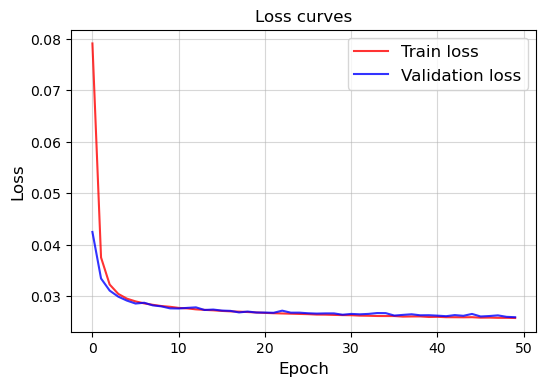

In [59]:
plt.figure(dpi=100)
plt.plot(train_log, c='red', label='Train loss', alpha=0.8)
plt.plot(val_log, c='blue', label='Validation loss', alpha=0.8)
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.legend(fontsize='12')
plt.title('Loss curves', size=12)
plt.grid(alpha=0.5)
#plt.yscale('log')

In [78]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(DEVICE)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples_df = pd.DataFrame(encoded_samples)

100%|██████████| 10000/10000 [00:04<00:00, 2336.55it/s]


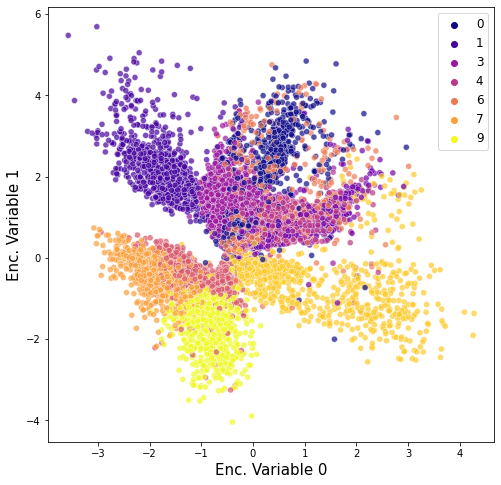

In [79]:
fig, ax = plt.subplots(figsize=(8,8), nrows=1, ncols=1)
sns.scatterplot(x='Enc. Variable 0', y='Enc. Variable 1',
                hue='label',
                data=encoded_samples_df,
                ax=ax,
                alpha=0.7,
                palette='plasma')
ax.legend(fontsize=12)
ax.set_xlabel('Enc. Variable 0', size=15)
ax.set_ylabel('Enc. Variable 1', size=15);

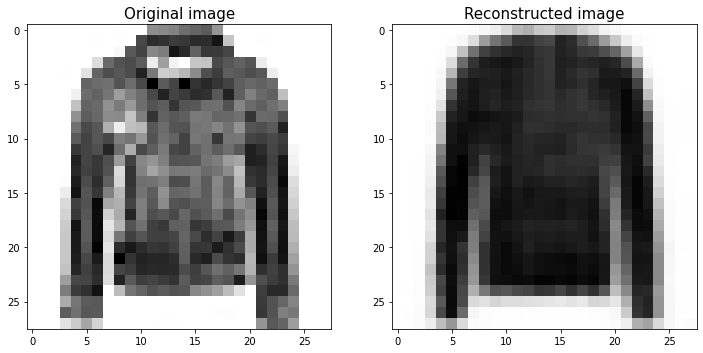

In [80]:
# Image reconstruction
idx = 6
image, label = train_dataset[idx]
encoder.eval()
decoder.eval()
with torch.no_grad():
    encoded_sample = encoder(image.unsqueeze_(0).to(DEVICE))
    decoded_sample = decoder(encoded_sample)
rec_image = decoded_sample.to('cpu').squeeze().numpy()

fig, ax = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)
ax[0].imshow(image.squeeze(), cmap='Greys')
ax[0].set_title('Original image', size=15)

ax[1].imshow(rec_image, cmap='Greys')
ax[1].set_title('Reconstructed image', size=15);

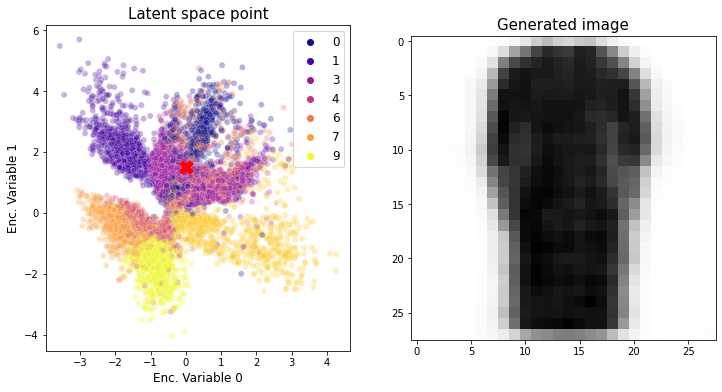

In [81]:
# Generating new images
ls_point = [0, 1.5]
encoded_sample = torch.Tensor(ls_point).unsqueeze_(0).to(DEVICE)
decoder.eval()
with torch.no_grad():
    decoded_sample = decoder(encoded_sample)

encoded_sample = encoded_sample.to('cpu').squeeze().numpy()
decoded_sample = decoded_sample.to('cpu').squeeze().numpy()

fig, ax = plt.subplots(figsize=(12,6), ncols=2, nrows=1)
sns.scatterplot(x='Enc. Variable 0', y='Enc. Variable 1',
                hue='label',
                data=encoded_samples_df,
                ax=ax[0],
                alpha=0.3,
                palette='plasma')
ax[0].legend(fontsize=12)
ax[0].set_xlabel('Enc. Variable 0', size=12)
ax[0].set_ylabel('Enc. Variable 1', size=12);
ax[0].scatter(*ls_point, s=180, color='red', marker='X')
ax[0].set_title('Latent space point', size=15)
ax[1].imshow(decoded_sample, cmap='Greys')
ax[1].set_title('Generated image', size=15);

In [ ]:
# Save results
results0 = pd.DataFrame(
    {
        'loss_curve' : train_log,
        'val_curve' : val_log
    }
)
results0.to_csv('results0.csv')

## Optimizers and regularization methods

Adding dropout

In [68]:
torch.manual_seed(0)

encoded_space_dim = 2
p_dropout = 0.2
encoder = Encoder(encoded_space_dim=2, dropout=p_dropout)
decoder = Decoder(encoded_space_dim=2, dropout=p_dropout)

loss_fn = torch.nn.MSELoss()
lr = 5e-4
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=0)

encoder.to(DEVICE)
decoder.to(DEVICE)

Decoder(
  (decoder_fc): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=64, out_features=288, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [69]:
results_df = pd.read_csv(f'parameters/results{p_dropout}.csv')
train_log = results_df['loss_curve']
val_log = results_df['val_curve']

encoder.load_state_dict(torch.load(f'parameters/encoder{p_dropout}_params.pth'))
decoder.load_state_dict(torch.load(f'parameters/decoder{p_dropout}_params.pth'))
encoder.eval()
decoder.eval()

Decoder(
  (decoder_fc): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=64, out_features=288, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [ ]:
num_epochs = 50
train_log = []
val_log = []
for epoch in range(num_epochs):
    train_loss = train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=DEVICE, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    
    val_loss = val_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=DEVICE, 
        dataloader=val_dataloader, 
        loss_fn=loss_fn)
    
    train_log.append(train_loss.cpu().numpy())
    val_log.append(val_loss.cpu().numpy())

    print('EPOCH %d/%d: TRAIN - loss: %f || VALIDATION - loss: %f' % (epoch + 1, num_epochs, train_loss, val_loss))

# Save network parameters
torch.save(encoder.state_dict(), f'encoder{p_dropout}_params.pth')
torch.save(decoder.state_dict(), f'decoder{p_dropout}_params.pth')

EPOCH 1/50: TRAIN - loss: 0.083531 || VALIDATION - loss: 0.043569
EPOCH 2/50: TRAIN - loss: 0.043841 || VALIDATION - loss: 0.036405
EPOCH 3/50: TRAIN - loss: 0.038796 || VALIDATION - loss: 0.033892
EPOCH 4/50: TRAIN - loss: 0.036533 || VALIDATION - loss: 0.032334
EPOCH 5/50: TRAIN - loss: 0.035430 || VALIDATION - loss: 0.031517
EPOCH 6/50: TRAIN - loss: 0.034711 || VALIDATION - loss: 0.031247
EPOCH 7/50: TRAIN - loss: 0.034227 || VALIDATION - loss: 0.030652
EPOCH 8/50: TRAIN - loss: 0.033832 || VALIDATION - loss: 0.030416
EPOCH 9/50: TRAIN - loss: 0.033581 || VALIDATION - loss: 0.030574
EPOCH 10/50: TRAIN - loss: 0.033339 || VALIDATION - loss: 0.030338
EPOCH 11/50: TRAIN - loss: 0.033133 || VALIDATION - loss: 0.030125
EPOCH 12/50: TRAIN - loss: 0.032951 || VALIDATION - loss: 0.029760
EPOCH 13/50: TRAIN - loss: 0.032785 || VALIDATION - loss: 0.029762
EPOCH 14/50: TRAIN - loss: 0.032636 || VALIDATION - loss: 0.029479
EPOCH 15/50: TRAIN - loss: 0.032434 || VALIDATION - loss: 0.029391
EPOC

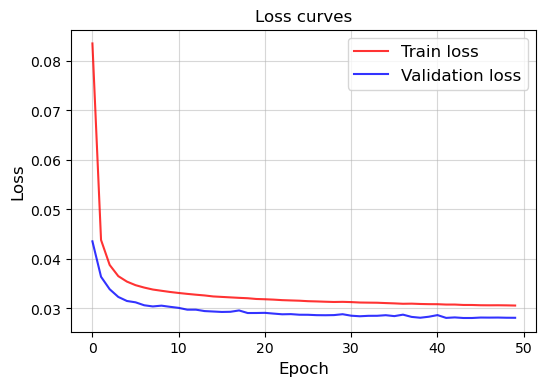

In [70]:
plt.figure(dpi=100)
plt.plot(train_log, c='red', label='Train loss', alpha=0.8)
plt.plot(val_log, c='blue', label='Validation loss', alpha=0.8)
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.legend(fontsize='12')
plt.title('Loss curves', size=12)
plt.grid(alpha=0.5)
#plt.yscale('log')

In [71]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(DEVICE)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples_df = pd.DataFrame(encoded_samples)

100%|██████████| 10000/10000 [00:04<00:00, 2295.47it/s]


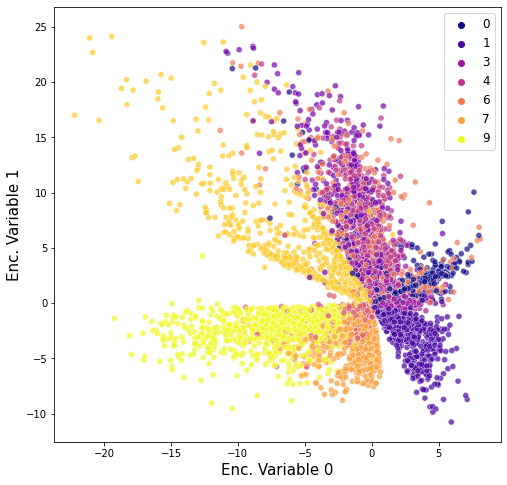

In [72]:
fig, ax = plt.subplots(figsize=(8,8), nrows=1, ncols=1)
sns.scatterplot(x='Enc. Variable 0', y='Enc. Variable 1',
                hue='label',
                data=encoded_samples_df,
                ax=ax,
                alpha=0.7,
                palette='plasma')
ax.legend(fontsize=12)
ax.set_xlabel('Enc. Variable 0', size=15)
ax.set_ylabel('Enc. Variable 1', size=15);

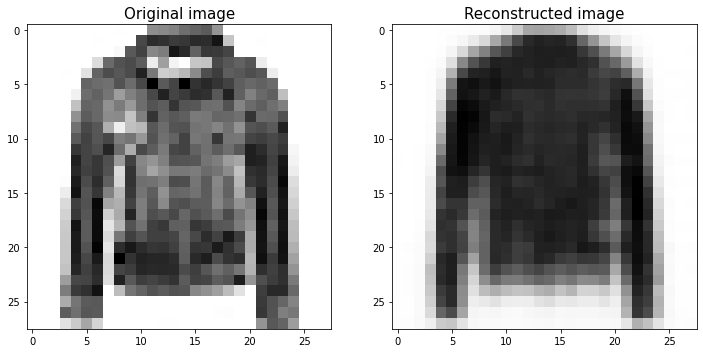

In [73]:
# Image reconstruction
idx = 6
image, label = train_dataset[idx]
encoder.eval()
decoder.eval()
with torch.no_grad():
    encoded_sample = encoder(image.unsqueeze_(0).to(DEVICE))
    decoded_sample = decoder(encoded_sample)
rec_image = decoded_sample.to('cpu').squeeze().numpy()

fig, ax = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)
ax[0].imshow(image.squeeze(), cmap='Greys')
ax[0].set_title('Original image', size=15)

ax[1].imshow(rec_image, cmap='Greys')
ax[1].set_title('Reconstructed image', size=15);

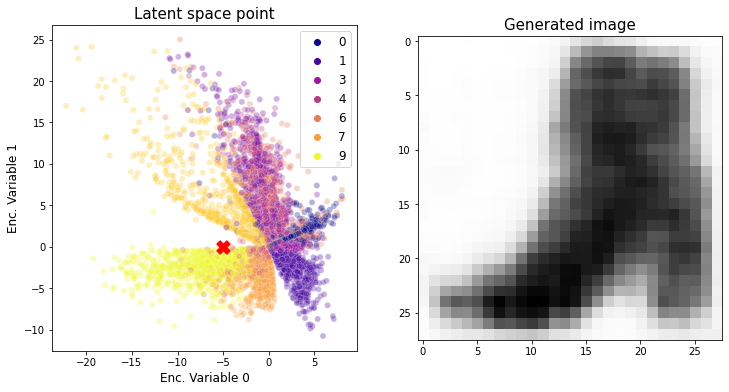

In [29]:
# Generating new images
ls_point = [-5, -0]
encoded_sample = torch.Tensor(ls_point).unsqueeze_(0).to(DEVICE)
decoder.eval()
with torch.no_grad():
    decoded_sample = decoder(encoded_sample)

encoded_sample = encoded_sample.to('cpu').squeeze().numpy()
decoded_sample = decoded_sample.to('cpu').squeeze().numpy()

fig, ax = plt.subplots(figsize=(12,6), ncols=2, nrows=1)
sns.scatterplot(x='Enc. Variable 0', y='Enc. Variable 1',
                hue='label',
                data=encoded_samples_df,
                ax=ax[0],
                alpha=0.3,
                palette='plasma')
ax[0].legend(fontsize=12)
ax[0].set_xlabel('Enc. Variable 0', size=12)
ax[0].set_ylabel('Enc. Variable 1', size=12);
ax[0].scatter(*ls_point, s=180, color='red', marker='X')
ax[0].set_title('Latent space point', size=15)
ax[1].imshow(decoded_sample, cmap='Greys')
ax[1].set_title('Generated image', size=15);

In [ ]:
# Save results
results = pd.DataFrame(
    {
        'loss_curve' : train_log,
        'val_curve' : val_log
    }
)
results.to_csv(f'results{p_dropout}.csv')

## Optimization over the latent space dimension

In [137]:
def objective(trial):
    latent_dim = trial.suggest_int('latent space dimension', 2, 20)
    encoder = Encoder(latent_dim, 0).to(DEVICE)
    decoder = Decoder(latent_dim, 0).to(DEVICE)
    loss_fn = torch.nn.MSELoss()
    lr = 5e-4
    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]
    optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

    num_epochs = 5

    for epoch in range(num_epochs):
        train_loss = train_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=DEVICE, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optim)
        
        val_loss = val_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=DEVICE, 
            dataloader=val_dataloader, 
            loss_fn=loss_fn)

        print('EPOCH %d/%d: TRAIN - loss: %f || VALIDATION - loss: %f' % (epoch + 1, num_epochs, train_loss, val_loss))
    return val_loss.cpu().numpy()

In [138]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=10)

[I 2022-06-25 13:03:21,800] A new study created in memory with name: no-name-0bbe84d1-254d-4f22-8933-c890b22989c0


EPOCH 1/5: TRAIN - loss: 0.077197 || VALIDATION - loss: 0.033506
EPOCH 2/5: TRAIN - loss: 0.027182 || VALIDATION - loss: 0.024008
EPOCH 3/5: TRAIN - loss: 0.021191 || VALIDATION - loss: 0.019497
EPOCH 4/5: TRAIN - loss: 0.018812 || VALIDATION - loss: 0.017953


[I 2022-06-25 13:03:50,216] Trial 0 finished with value: 0.01724020205438137 and parameters: {'latent space dimension': 10}. Best is trial 0 with value: 0.01724020205438137.


EPOCH 5/5: TRAIN - loss: 0.017674 || VALIDATION - loss: 0.017240
EPOCH 1/5: TRAIN - loss: 0.085098 || VALIDATION - loss: 0.035533
EPOCH 2/5: TRAIN - loss: 0.028015 || VALIDATION - loss: 0.022287
EPOCH 3/5: TRAIN - loss: 0.020715 || VALIDATION - loss: 0.018952
EPOCH 4/5: TRAIN - loss: 0.018002 || VALIDATION - loss: 0.017209


[I 2022-06-25 13:04:18,436] Trial 1 finished with value: 0.015781501308083534 and parameters: {'latent space dimension': 18}. Best is trial 1 with value: 0.015781501308083534.


EPOCH 5/5: TRAIN - loss: 0.016360 || VALIDATION - loss: 0.015782
EPOCH 1/5: TRAIN - loss: 0.082720 || VALIDATION - loss: 0.037001
EPOCH 2/5: TRAIN - loss: 0.028911 || VALIDATION - loss: 0.023606
EPOCH 3/5: TRAIN - loss: 0.021572 || VALIDATION - loss: 0.019811
EPOCH 4/5: TRAIN - loss: 0.019030 || VALIDATION - loss: 0.018248


[I 2022-06-25 13:04:46,356] Trial 2 finished with value: 0.01719796657562256 and parameters: {'latent space dimension': 11}. Best is trial 1 with value: 0.015781501308083534.


EPOCH 5/5: TRAIN - loss: 0.017742 || VALIDATION - loss: 0.017198
EPOCH 1/5: TRAIN - loss: 0.072150 || VALIDATION - loss: 0.035443
EPOCH 2/5: TRAIN - loss: 0.029285 || VALIDATION - loss: 0.025350
EPOCH 3/5: TRAIN - loss: 0.023850 || VALIDATION - loss: 0.022607
EPOCH 4/5: TRAIN - loss: 0.021942 || VALIDATION - loss: 0.021417


[I 2022-06-25 13:05:14,661] Trial 3 finished with value: 0.02072210982441902 and parameters: {'latent space dimension': 5}. Best is trial 1 with value: 0.015781501308083534.


EPOCH 5/5: TRAIN - loss: 0.021064 || VALIDATION - loss: 0.020722
EPOCH 1/5: TRAIN - loss: 0.078896 || VALIDATION - loss: 0.034921
EPOCH 2/5: TRAIN - loss: 0.027618 || VALIDATION - loss: 0.022848
EPOCH 3/5: TRAIN - loss: 0.020893 || VALIDATION - loss: 0.019219
EPOCH 4/5: TRAIN - loss: 0.018373 || VALIDATION - loss: 0.017494


[I 2022-06-25 13:05:42,878] Trial 4 finished with value: 0.016700655221939087 and parameters: {'latent space dimension': 13}. Best is trial 1 with value: 0.015781501308083534.


EPOCH 5/5: TRAIN - loss: 0.017156 || VALIDATION - loss: 0.016701
EPOCH 1/5: TRAIN - loss: 0.087185 || VALIDATION - loss: 0.031005
EPOCH 2/5: TRAIN - loss: 0.025546 || VALIDATION - loss: 0.022192
EPOCH 3/5: TRAIN - loss: 0.020725 || VALIDATION - loss: 0.019428
EPOCH 4/5: TRAIN - loss: 0.018518 || VALIDATION - loss: 0.018328


[I 2022-06-25 13:06:11,234] Trial 5 finished with value: 0.01706664077937603 and parameters: {'latent space dimension': 13}. Best is trial 1 with value: 0.015781501308083534.


EPOCH 5/5: TRAIN - loss: 0.017434 || VALIDATION - loss: 0.017067
EPOCH 1/5: TRAIN - loss: 0.077059 || VALIDATION - loss: 0.030775
EPOCH 2/5: TRAIN - loss: 0.024227 || VALIDATION - loss: 0.020673
EPOCH 3/5: TRAIN - loss: 0.019143 || VALIDATION - loss: 0.017933
EPOCH 4/5: TRAIN - loss: 0.017323 || VALIDATION - loss: 0.017125


[I 2022-06-25 13:06:39,546] Trial 6 finished with value: 0.01625625602900982 and parameters: {'latent space dimension': 13}. Best is trial 1 with value: 0.015781501308083534.


EPOCH 5/5: TRAIN - loss: 0.016417 || VALIDATION - loss: 0.016256
EPOCH 1/5: TRAIN - loss: 0.056448 || VALIDATION - loss: 0.028719
EPOCH 2/5: TRAIN - loss: 0.024584 || VALIDATION - loss: 0.021425
EPOCH 3/5: TRAIN - loss: 0.020216 || VALIDATION - loss: 0.018921
EPOCH 4/5: TRAIN - loss: 0.018342 || VALIDATION - loss: 0.017649


[I 2022-06-25 13:07:07,878] Trial 7 finished with value: 0.017124267295002937 and parameters: {'latent space dimension': 11}. Best is trial 1 with value: 0.015781501308083534.


EPOCH 5/5: TRAIN - loss: 0.017277 || VALIDATION - loss: 0.017124
EPOCH 1/5: TRAIN - loss: 0.075329 || VALIDATION - loss: 0.035373
EPOCH 2/5: TRAIN - loss: 0.027644 || VALIDATION - loss: 0.022848
EPOCH 3/5: TRAIN - loss: 0.021645 || VALIDATION - loss: 0.020002
EPOCH 4/5: TRAIN - loss: 0.019322 || VALIDATION - loss: 0.018410


[I 2022-06-25 13:07:35,924] Trial 8 finished with value: 0.017533419653773308 and parameters: {'latent space dimension': 10}. Best is trial 1 with value: 0.015781501308083534.


EPOCH 5/5: TRAIN - loss: 0.018000 || VALIDATION - loss: 0.017533
EPOCH 1/5: TRAIN - loss: 0.055024 || VALIDATION - loss: 0.028685
EPOCH 2/5: TRAIN - loss: 0.023390 || VALIDATION - loss: 0.021013
EPOCH 3/5: TRAIN - loss: 0.019104 || VALIDATION - loss: 0.018108
EPOCH 4/5: TRAIN - loss: 0.017513 || VALIDATION - loss: 0.016859


[I 2022-06-25 13:08:03,990] Trial 9 finished with value: 0.0161877553910017 and parameters: {'latent space dimension': 12}. Best is trial 1 with value: 0.015781501308083534.


EPOCH 5/5: TRAIN - loss: 0.016652 || VALIDATION - loss: 0.016188


In [139]:
# Save network parameters
torch.save(encoder.state_dict(), 'encoder_best_params.pth')
torch.save(decoder.state_dict(), 'decoder_best_params.pth')

In [140]:
best_latent_dim = study.best_params['latent space dimension']
encoder = Encoder(best_latent_dim, 0).to(DEVICE)
decoder = Decoder(best_latent_dim, 0).to(DEVICE)
loss_fn = torch.nn.MSELoss()
lr = 5e-4
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

In [141]:
num_epochs = 50
train_log = []
val_log = []
for epoch in range(num_epochs):
    train_loss = train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=DEVICE, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    
    val_loss = val_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=DEVICE, 
        dataloader=val_dataloader, 
        loss_fn=loss_fn)
    
    train_log.append(train_loss.cpu().numpy())
    val_log.append(val_loss.cpu().numpy())

    print('EPOCH %d/%d: TRAIN - loss: %f || VALIDATION - loss: %f' % (epoch + 1, num_epochs, train_loss, val_loss))

# Save network parameters
torch.save(encoder.state_dict(), 'parameters/encoder_best_params.pth')
torch.save(decoder.state_dict(), 'parameters/decoder_best_params.pth')

EPOCH 1/50: TRAIN - loss: 0.065151 || VALIDATION - loss: 0.029621
EPOCH 2/50: TRAIN - loss: 0.025171 || VALIDATION - loss: 0.021285
EPOCH 3/50: TRAIN - loss: 0.020249 || VALIDATION - loss: 0.018640
EPOCH 4/50: TRAIN - loss: 0.018023 || VALIDATION - loss: 0.017293
EPOCH 5/50: TRAIN - loss: 0.016681 || VALIDATION - loss: 0.016101
EPOCH 6/50: TRAIN - loss: 0.015675 || VALIDATION - loss: 0.015415
EPOCH 7/50: TRAIN - loss: 0.014932 || VALIDATION - loss: 0.014620
EPOCH 8/50: TRAIN - loss: 0.014461 || VALIDATION - loss: 0.014205
EPOCH 9/50: TRAIN - loss: 0.014129 || VALIDATION - loss: 0.013860
EPOCH 10/50: TRAIN - loss: 0.013814 || VALIDATION - loss: 0.013880
EPOCH 11/50: TRAIN - loss: 0.013605 || VALIDATION - loss: 0.013336
EPOCH 12/50: TRAIN - loss: 0.013373 || VALIDATION - loss: 0.013251
EPOCH 13/50: TRAIN - loss: 0.013185 || VALIDATION - loss: 0.013189
EPOCH 14/50: TRAIN - loss: 0.012984 || VALIDATION - loss: 0.013818
EPOCH 15/50: TRAIN - loss: 0.012841 || VALIDATION - loss: 0.012731
EPOC

In [142]:
results_df = pd.read_csv(f'parameters/results_best.csv')
train_log = results_df['loss_curve']
val_log = results_df['val_curve']

encoder.load_state_dict(torch.load(f'parameters/encoder_best_params.pth'))
decoder.load_state_dict(torch.load(f'parameters/decoder_best_params.pth'))
encoder.eval()
decoder.eval()

Decoder(
  (decoder_fc): Sequential(
    (0): Linear(in_features=18, out_features=64, bias=True)
    (1): Dropout(p=0, inplace=False)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=64, out_features=288, bias=True)
    (4): Dropout(p=0, inplace=False)
    (5): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

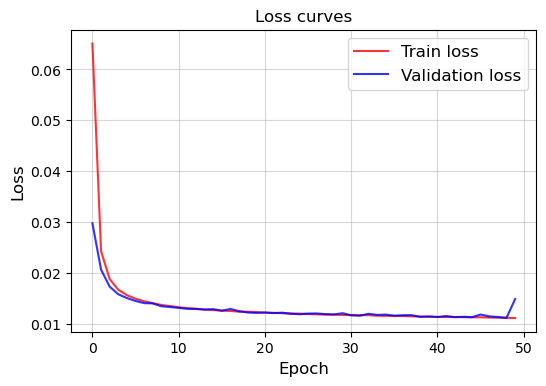

In [143]:
plt.figure(dpi=100)
plt.plot(train_log, c='red', label='Train loss', alpha=0.8)
plt.plot(val_log, c='blue', label='Validation loss', alpha=0.8)
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.legend(fontsize='12')
plt.title('Loss curves', size=12)
plt.grid(alpha=0.5)
#plt.yscale('log')

In [144]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(DEVICE)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)

100%|██████████| 10000/10000 [00:04<00:00, 2266.70it/s]


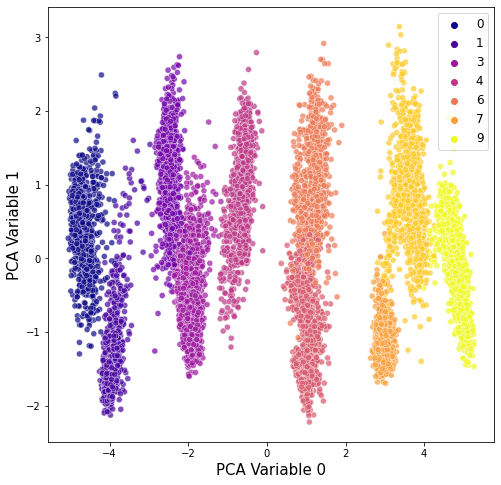

In [145]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)
encoded_samples_reduced_PCA

fig, ax = plt.subplots(figsize=(8,8), nrows=1, ncols=1)
sns.scatterplot(x=encoded_samples_reduced_PCA[:,0], y=encoded_samples_reduced_PCA[:,1],
                hue=encoded_samples.label.to_numpy(),
                ax=ax,
                alpha=0.7,
                palette='plasma')
ax.legend(fontsize=12)
ax.set_xlabel('PCA Variable 0', size=15)
ax.set_ylabel('PCA Variable 1', size=15);

In [146]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)

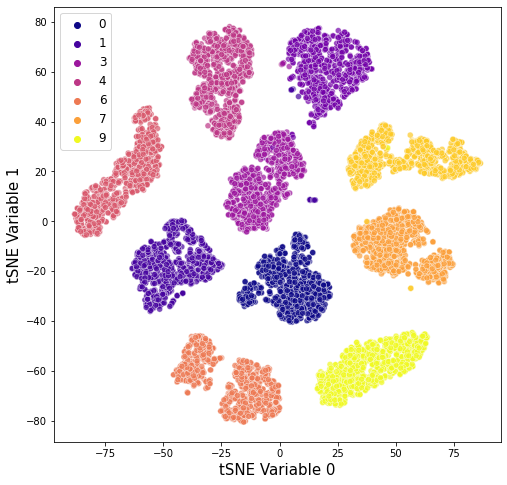

In [147]:
fig, ax = plt.subplots(figsize=(8,8), nrows=1, ncols=1)
sns.scatterplot(x=encoded_samples_reduced_TSNE[:,0], y=encoded_samples_reduced_TSNE[:,1],
                hue=encoded_samples.label.to_numpy(),
                ax=ax,
                alpha=0.7,
                palette='plasma')
ax.legend(fontsize=12)
ax.set_xlabel('tSNE Variable 0', size=15)
ax.set_ylabel('tSNE Variable 1', size=15);

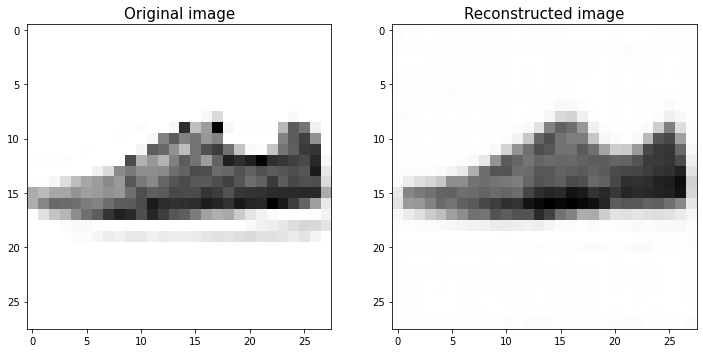

In [148]:
# Image reconstruction
idx = 1
image, label = train_dataset[idx]
encoder.eval()
decoder.eval()
with torch.no_grad():
    encoded_sample = encoder(image.unsqueeze_(0).to(DEVICE))
    decoded_sample = decoder(encoded_sample)
rec_image = decoded_sample.to('cpu').squeeze().numpy()

fig, ax = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)
ax[0].imshow(image.squeeze(), cmap='Greys')
ax[0].set_title('Original image', size=15)

ax[1].imshow(rec_image, cmap='Greys')
ax[1].set_title('Reconstructed image', size=15);

In [149]:
# Save results
results = pd.DataFrame(
    {
        'loss_curve' : train_log,
        'val_curve' : val_log
    }
)
results.to_csv('results_best.csv')

## Classification task

In [150]:
import torch.optim as optim

In [151]:
#best_latent_dim = 20
encoder = Encoder(best_latent_dim, 0)
encoder.load_state_dict(torch.load('parameters/encoder_best_params.pth'))
encoder.to(DEVICE)

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_fc): Sequential(
    (0): Linear(in_features=288, out_features=64, bias=True)
    (1): Dropout(p=0, inplace=False)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=64, out_features=18, bias=True)
  )
)

In [152]:
class Classifier_net(nn.Module):
    """
    Three layers fc network
    """

    def __init__(self, params):
        super().__init__()
        self.fc0 = nn.Linear(in_features=params['latent_space_dimension'],
                             out_features=params['features_fc0'])
        self.fc1 = nn.Linear(in_features=params['features_fc0'],
                             out_features=params['features_fc1'])
        self.fc2 = nn.Linear(in_features=params['features_fc1'],
                             out_features=10)
        self.dropout = nn.Dropout(params['p_dropout'])
        
    def forward(self, x):
        x = self.fc0(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [153]:
def train_epoch_classifier(encoder, classifier_net, optimizer, loss_fn, device, dataloader):
    train_loss = []
    classifier_net.train()
    for sample_batch in dataloader:
        image_batch = sample_batch[0].to(device)
        label_batch = sample_batch[1].to(device)
        encoded_image = encoder(image_batch)
        classifier_output = classifier_net(encoded_image)
        loss = loss_fn(classifier_output, label_batch)
        classifier_net.zero_grad()
        loss.backward()
        optimizer.step()
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)
    return np.mean(train_loss)

def val_epoch_classifier(encoder, classifier_net, loss_fn, device, dataloader):
    val_loss = []
    correct = 0
    total = 0
    classifier_net.eval()
    with torch.no_grad():
        for sample_batch in dataloader:
            image_batch = sample_batch[0].to(device)
            label_batch = sample_batch[1].to(device)
            encoded_image = encoder(image_batch)
            classifier_output = classifier_net(encoded_image)
            _, predicted = torch.max(classifier_output.data, 1)
            total += label_batch.size(0)
            correct += (predicted == label_batch).sum().item()
            loss = loss_fn(classifier_output, label_batch)
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)
    accuracy = 100 * correct / total
    return np.mean(val_loss), accuracy

In [154]:
def objective(trial):
    params = {
        'latent_space_dimension' : best_latent_dim,
        'features_fc0' : trial.suggest_int('features_fc0', 64, 256),
        'features_fc1' : trial.suggest_int('features_fc1', 32, 64),
        'p_dropout' : trial.suggest_float('p_dropout', 0., 0.2)
    }

    classifier_net = Classifier_net(params).to(DEVICE)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier_net.parameters(), lr=1e-3)
    
    num_epochs = 5
    for epoch in range(num_epochs):
        _ = train_epoch_classifier(encoder, classifier_net, optimizer, loss_fn, DEVICE, train_dataloader)
        _, accuracy = val_epoch_classifier(encoder, classifier_net, loss_fn, DEVICE, val_dataloader)
        print('EPOCH {:}/{:} - val accuracy: {:.2f}'.format(epoch+1, num_epochs, accuracy))
    
    return accuracy

In [155]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=10)

[I 2022-06-25 13:13:06,036] A new study created in memory with name: no-name-ff0b70b6-7d51-4318-9d7b-dc81d923a90b


EPOCH 1/5 - val accuracy: 78.04
EPOCH 2/5 - val accuracy: 80.32
EPOCH 3/5 - val accuracy: 82.39
EPOCH 4/5 - val accuracy: 83.18


[I 2022-06-25 13:13:30,833] Trial 0 finished with value: 83.56 and parameters: {'features_fc0': 107, 'features_fc1': 41, 'p_dropout': 0.011195368085519776}. Best is trial 0 with value: 83.56.


EPOCH 5/5 - val accuracy: 83.56
EPOCH 1/5 - val accuracy: 78.68
EPOCH 2/5 - val accuracy: 81.67
EPOCH 3/5 - val accuracy: 82.63
EPOCH 4/5 - val accuracy: 83.61


[I 2022-06-25 13:13:55,632] Trial 1 finished with value: 83.87 and parameters: {'features_fc0': 153, 'features_fc1': 33, 'p_dropout': 0.09485954969827677}. Best is trial 1 with value: 83.87.


EPOCH 5/5 - val accuracy: 83.87
EPOCH 1/5 - val accuracy: 76.29
EPOCH 2/5 - val accuracy: 80.93
EPOCH 3/5 - val accuracy: 82.00
EPOCH 4/5 - val accuracy: 82.39


[I 2022-06-25 13:14:20,417] Trial 2 finished with value: 83.01 and parameters: {'features_fc0': 93, 'features_fc1': 38, 'p_dropout': 0.14907304920896167}. Best is trial 1 with value: 83.87.


EPOCH 5/5 - val accuracy: 83.01
EPOCH 1/5 - val accuracy: 79.87
EPOCH 2/5 - val accuracy: 82.31
EPOCH 3/5 - val accuracy: 82.73
EPOCH 4/5 - val accuracy: 84.10


[I 2022-06-25 13:14:45,199] Trial 3 finished with value: 84.62 and parameters: {'features_fc0': 225, 'features_fc1': 40, 'p_dropout': 0.14977177338804776}. Best is trial 3 with value: 84.62.


EPOCH 5/5 - val accuracy: 84.62
EPOCH 1/5 - val accuracy: 79.03
EPOCH 2/5 - val accuracy: 81.90
EPOCH 3/5 - val accuracy: 82.74
EPOCH 4/5 - val accuracy: 83.55


[I 2022-06-25 13:15:09,904] Trial 4 finished with value: 83.83 and parameters: {'features_fc0': 114, 'features_fc1': 62, 'p_dropout': 0.17687752760746042}. Best is trial 3 with value: 84.62.


EPOCH 5/5 - val accuracy: 83.83
EPOCH 1/5 - val accuracy: 79.70
EPOCH 2/5 - val accuracy: 82.35
EPOCH 3/5 - val accuracy: 83.68
EPOCH 4/5 - val accuracy: 84.24


[I 2022-06-25 13:15:34,611] Trial 5 finished with value: 85.22 and parameters: {'features_fc0': 173, 'features_fc1': 58, 'p_dropout': 0.0690491991974208}. Best is trial 5 with value: 85.22.


EPOCH 5/5 - val accuracy: 85.22
EPOCH 1/5 - val accuracy: 79.76
EPOCH 2/5 - val accuracy: 82.41
EPOCH 3/5 - val accuracy: 83.70
EPOCH 4/5 - val accuracy: 84.20


[I 2022-06-25 13:15:59,659] Trial 6 finished with value: 84.5 and parameters: {'features_fc0': 174, 'features_fc1': 47, 'p_dropout': 0.07845541614617849}. Best is trial 5 with value: 85.22.


EPOCH 5/5 - val accuracy: 84.50
EPOCH 1/5 - val accuracy: 81.00
EPOCH 2/5 - val accuracy: 82.72
EPOCH 3/5 - val accuracy: 83.87
EPOCH 4/5 - val accuracy: 84.21


[I 2022-06-25 13:16:24,714] Trial 7 finished with value: 84.38 and parameters: {'features_fc0': 239, 'features_fc1': 45, 'p_dropout': 0.09252687200858951}. Best is trial 5 with value: 85.22.


EPOCH 5/5 - val accuracy: 84.38
EPOCH 1/5 - val accuracy: 79.55
EPOCH 2/5 - val accuracy: 82.04
EPOCH 3/5 - val accuracy: 83.51
EPOCH 4/5 - val accuracy: 83.96


[I 2022-06-25 13:16:49,852] Trial 8 finished with value: 84.09 and parameters: {'features_fc0': 196, 'features_fc1': 55, 'p_dropout': 0.1020940968190744}. Best is trial 5 with value: 85.22.


EPOCH 5/5 - val accuracy: 84.09
EPOCH 1/5 - val accuracy: 79.36
EPOCH 2/5 - val accuracy: 82.05
EPOCH 3/5 - val accuracy: 83.18
EPOCH 4/5 - val accuracy: 84.16


[I 2022-06-25 13:17:15,030] Trial 9 finished with value: 84.75 and parameters: {'features_fc0': 160, 'features_fc1': 48, 'p_dropout': 0.13472391699846883}. Best is trial 5 with value: 85.22.


EPOCH 5/5 - val accuracy: 84.75


In [156]:
best_params = study.best_params.copy()
best_params['latent_space_dimension'] = best_latent_dim

In [157]:
classifier_net = Classifier_net(best_params).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier_net.parameters(), lr=1e-3)

num_epochs = 50
log_train = []
log_test = []
log_accuracy = []
for epoch in range(num_epochs):
    train_loss = train_epoch_classifier(encoder, classifier_net, optimizer, loss_fn, DEVICE, train_dataloader)
    test_loss, accuracy = val_epoch_classifier(encoder, classifier_net, loss_fn, DEVICE, test_dataloader)
    log_train.append(train_loss)
    log_test.append(test_loss)
    log_accuracy.append(accuracy)
    print('EPOCH {:}/{:} - test accuracy: {:.2f}'.format(epoch+1, num_epochs, accuracy))

EPOCH 1/50 - test accuracy: 79.14
EPOCH 2/50 - test accuracy: 80.85
EPOCH 3/50 - test accuracy: 81.50
EPOCH 4/50 - test accuracy: 82.41
EPOCH 5/50 - test accuracy: 83.37
EPOCH 6/50 - test accuracy: 83.55
EPOCH 7/50 - test accuracy: 83.75
EPOCH 8/50 - test accuracy: 83.85
EPOCH 9/50 - test accuracy: 84.10
EPOCH 10/50 - test accuracy: 84.14
EPOCH 11/50 - test accuracy: 84.20
EPOCH 12/50 - test accuracy: 84.41
EPOCH 13/50 - test accuracy: 84.32
EPOCH 14/50 - test accuracy: 84.62
EPOCH 15/50 - test accuracy: 84.87
EPOCH 16/50 - test accuracy: 84.66
EPOCH 17/50 - test accuracy: 84.83
EPOCH 18/50 - test accuracy: 85.01
EPOCH 19/50 - test accuracy: 85.05
EPOCH 20/50 - test accuracy: 84.66
EPOCH 21/50 - test accuracy: 84.96
EPOCH 22/50 - test accuracy: 85.27
EPOCH 23/50 - test accuracy: 85.21
EPOCH 24/50 - test accuracy: 85.25
EPOCH 25/50 - test accuracy: 85.09
EPOCH 26/50 - test accuracy: 85.48
EPOCH 27/50 - test accuracy: 85.10
EPOCH 28/50 - test accuracy: 85.52
EPOCH 29/50 - test accuracy: 

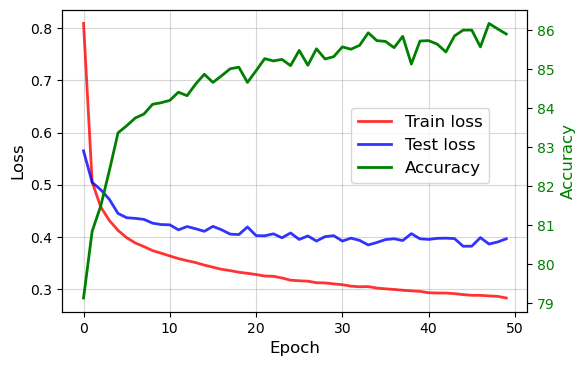

In [158]:
fig, ax = plt.subplots(dpi=100)
ax.plot(log_train, c='red', label='Train loss', alpha=0.8, lw=2)
ax.plot(log_test, c='blue', label='Test loss', alpha=0.8, lw=2)
ax.set_xlabel('Epoch', size=12)
ax.set_ylabel('Loss', size=12)
ax.grid(alpha=0.5)

ax2 = ax.twinx()
ax2.plot(log_accuracy, label='Accuracy', lw=2, c='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_ylabel('Accuracy', size=12, c='green')

fig.legend(loc=(0.6, 0.5), fontsize=12);